### Astro 304 (Spring 2017) "Galaxies"

### Homework 6 (40 points +  several extra-credit problems)

### Due, Friday, June 2, 9pm

### Exploring galaxy evolution and scaling relations

In this homework, you will continue to explore the galaxy formation model we built, but now we will focus on the gas and heavy elements (metallicity) content of model galaxies and how they compare to relevant observations. Before you work on this homework, please compare your results from HW 4-5 with mine. Fix errors in the galaxy formation model, if needed.

The homework contains 8 *possible* exercises. <b>Pick 2 or 3 of these that you'd like, so that the total is 40 points or more</b> and do those. You can treat the rest as extra-credit problems. 

In [232]:
# setup notebook for inline figures
%matplotlib inline
import numpy as np

# import pyplot and set some parameters to make plots prettier
import matplotlib.pyplot as plt
from code.plot_utils import plot_pretty
plot_pretty()

### Setting up previous homework updates.

In [233]:
# Taken from akravstov hw05_solutions


import code.galaxy_model as gm
import numpy as np
from scipy.integrate import odeint
from scipy.interpolate import UnivariateSpline
from colossus.halo.mass_so import M_to_R
from colossus.halo.concentration import concentration
from colossus.halo.mass_defs import changeMassDefinition
#
# inherit the model with UV and shock heating, add model for molecular gas
#
class gmodel_r50(gm.gmodel_heating):

    def __init__(self, *args, **kwargs):

        # process kwargs and remove (via kwargs.pop extraction) those
        # keyword arguments that should not be passed to parent init
        if 'ac' in kwargs: # Flag to use adiabatic contraction correction
            self.ac = kwargs.pop('ac')
        else:
            self.ac = 'off'
        # factor in front of the MMW98 expression for Rd to set the fraction
        # of angular momentum lost during galaxy evolution
        if 'etar' in kwargs:
            self.etar = kwargs.pop('etar')
        else:
            self.etar = 1.0
                                                
        if 'verbose' in kwargs:
            self.verbose = kwargs['verbose']
        else:
            self.verbose = False
            
        if 'tausf' in kwargs:
            self.tausf = kwargs.pop('tausf')
        else:
            self.tausf = 2.0
            
        if 'sfrmodel' in kwargs:
            self.sfr_models = {'gaslinear': self.SFRgaslinear}
            try: 
                self.sfr_models[kwargs['sfrmodel']]
            except KeyError:
                print "unrecognized sfrmodel in model_galaxy.__init__:", sfrmodel
                print "available models:", self.sfr_models
                return
            self.sfrmodel = kwargs['sfrmodel']
        else:
            errmsg = 'to initialize gal object it is mandatory to supply sfrmodel!'
            raise Exception(errmsg)
            return
                
        # initialize everything in the parent class
        super(gmodel_r50, self).__init__(*args, **kwargs)
        
        return

    def eta50_MMW98(self, c, jmlam, md):
        """
        compute the factor between r50 and R200c in the MMW98 model
        input: c=concentration; jmlam = (j_d/m_d)*lambda; md = M*/M200c
        """
        # see eq. 23 in Mo, Mao & White 1998
        fc = 0.5*c*(1.-1./(1.+c)**2-2.*np.log(1.+c)/(1.+c))/(c/(1.+c)-np.log(1.+c))**2
        # use the expression below if you want to include full MMW98 model that includes adiabatic contraction
        if self.ac == 'off':
            fR = 1.0
        else:
            fR = (jmlam/0.1)**(-0.06+2.71*md+0.0047/jmlam)*(1.-3.*md+5.2*md**2)*(1.-0.019*c+2.5e-4*c*c+0.52/c)
        eta = 1.187/np.sqrt(fc)*jmlam*fR
        return eta

    def r_50(self, t):
        # Rdisk using formula from Mo, Mao & White 1998
        Mhh = self.Mh * self.cosmo.h
        cvir = concentration(Mhh, 'vir', self.z, model='diemer15')
        M200c, R200c, c200c = changeMassDefinition(Mhh, cvir, self.z, 'vir', '200c')
        md = self.Ms/(M200c/self.cosmo.h); 
        jmlam = self.etar*0.045 # assume etar fraction of the angular momentum lost
        eta50 = self.eta50_MMW98(c200c, jmlam, md)
        r_50 = eta50 * R200c / self.cosmo.h
        return r_50 
    
    def R_d(self, t):
        rd = self.r50(t)/1.687
        return rd 
     
    # redefine star formation function to use tau_sf that can be set on input
    def SFRgaslinear(self, t):
        return self.Mg/self.tausf

    
# "the class gmodel_wind is inherited...all the features of the 
# model that we've added so far, but adds different options for 
# the function ϵout."

class gmodel_wind(gmodel_r50):

    def __init__(self, *args, **kwargs):

        self.wind_models = {'constload': self.constwindload, 
                            'Muratov15': self.Muratov15wind, 
                            'Muratov15mod': self.Muratov15modified}
        if 'windmodel' in kwargs: 
            try: 
                windmodel = kwargs.pop('windmodel')
                self.wind_models[windmodel]
            except KeyError:
                print "unrecognized windmodel in model_galaxy.__init__:", windmodel
                print "available models:", self.wind_models
                return
            self.windmodel = windmodel
            self.etawind = kwargs.pop('etawind')
               
        else:
            errmsg = 'to initialize gal object it is mandatory to supply windmodel!'
            raise Exception(errmsg)
            return
                                
        # initialize everything in the parent class
        super(gmodel_wind, self).__init__(*args, **kwargs)
        
        return

    def Muratov15wind(self):
        if self.Ms > 0.:
            return self.etawind*(self.Ms/1.e10)**(-0.35)
        else:
            return 0.

    def Muratov15modified(self):
        if self.Ms > 0.:
            return np.maximum(2.0,self.etawind*(self.Ms/1.e10)**(-0.35) - 1.6)
        else:
            return 0.
        
    def constwindload(self):
        return self.etawind # etawind = 0 means no wind

    def eps_out(self):
        return self.wind_models[self.windmodel]()

### gmodel_grid Class
Define new gmodel_grid class to conveniently store the results from grid runs and avoid pesky renaming issues. All X-Y relation plotting functions will be here along with the grid calculation function.

In [256]:
########################################################################
########################################################################

# SECTION 0. gmodel_grid Class

########################################################################
########################################################################

from colossus.cosmology import cosmology
from scipy.interpolate import interp2d



class gmodel_grid():
    '''
    Class to contain the growing number of data we want to save after
    running a grid of our galaxy models. Send it the 4 mass splines 
    calculated by the galaxy model.
    
    Plottable relations currently include: ['Mh-Ms', 'Zs-Ms', 'Zg-Ms', 
    'yeff-Ms'].
    
    Attributes
    ----------
    lMhdomain (np.ndarray) : domain of initial halo masses for which the
                             galaxy model was evolved.
    
    zdomain   (np.ndarray) : domain of z values on which the galaxy
                             was evolved.
    
                        
    lMhplot (np array): array of starting halo masses for which you
                        wish to plot. Should be same as domain of
                        your galaxy model calculation.
    '''
    def __init__(self, zmin  = 0., zmax  = 30., Nz = 81, 
                       Mhmin = 5., Mhmax = 8.,  Nm = 60, gmodel = None, 
                       Z_IGM = 2.e-5, sfrmodel='gaslinear', tausf=1.0, 
                       windmodel='nowind', ac='off', etawind=1.0, 
                       cosmo = None):
        # z axis of grid
        self.Nz = Nz
        zgrid = np.linspace(zmax, zmin, Nz)
        lzg1 = np.log10(1.0 + zgrid)
        tgrid = cosmo.age(zgrid)
        self.tdomain = tgrid
        self.zdomain = zgrid
        
        # Mh axis of grid
        self.Nm = Nm
        lMh = np.linspace(Mhmin, Mhmax, Nm)
        Mh  = np.power(10, lMh)
        self.lMhdomain = lMh
    
        # Set galaxy model parameters
        #self.__set_model()
        self.galmodel  = gmodel
        self.ZIGM      = Z_IGM
        self.SFRmodel  = sfrmodel
        self.tauSF     = tausf
        self.windmodel = windmodel
        self.ac        = ac
        self.loading   = etawind
        self.cosmo     = cosmo


    #def __set_model(self, gmodel = None, Z_IGM = 2.e-5, 
    #                sfrmodel='gaslinear', tausf=1.0, windmodel='nowind', 
    #                ac='off', etawind=1.0, cosmo = None):
    #    self.galmodel  = gmodel
    #    self.ZIGM      = Z_IGM
    #    self.SFRmodel  = SFRmodel
    #    self.tauSF     = tausf
    #    self.windmodel = windmodel
    #    self.ac        = ac
    #    self.loading   = etawind
    #    self.cosmo     = cosmo
        
    def __set_masses(self, lMhi, lMgi, lMsi, lMZi):
        self.logMhgrid = lMhi
        self.logMggrid = lMgi
        self.logMsgrid = lMsi
        self.logMZgrid = lMZi
        
    def __set_r50(self, r50i):
        self.r50grid = r50i
        
########################################################################

# SECTION 0.1. Calculate on Mh-z rectangle

########################################################################

        
    def compute_mass_grid(self):
        '''
        Evolve galaxy over Nz number of steps in redshift and Nm number
        of halo mass steps. Sets the mass attributes for the grid class
        and returns them (for convenience/debugging).
        '''
        # grid of redshifts and halo masses
        zg = self.zdomain
        lzg1 = np.log10(1.0+zg)

        Mh  = np.power(10, self.lMhdomain)

        # arrays to hold evolutionary grids of halo mass, gas mass, stellar mass and metal mass
        Mhout  = np.zeros((self.Nm,self.Nz))
        Mgout  = np.zeros_like(Mhout)
        Msout  = np.zeros_like(Mhout)
        MZout  = np.zeros_like(Mhout)
        r50out = np.zeros_like(Mhout)
        #evolve a grid of halo masses
        
        t_output  = self.tdomain
        Z_IGM     = self.ZIGM
        sfrmodel  = self.SFRmodel
        tausf     = self.tauSF
        windmodel = self.windmodel
        ac        = self.ac
        etawind   = self.loading
        cosmo     = self.cosmo
        print("evolving mass grid...")
        for j, Mhd in enumerate(Mh):
            # instantiate a model galaxy with a given halo mass at the initial time
            g = self.galmodel(t = t_output[0], Mh = Mhd, Mg = None, Ms = None, MZ = None, Z_IGM = Z_IGM, 
                               sfrmodel = sfrmodel, tausf=tausf, windmodel = windmodel, ac=ac, etawind=etawind, cosmo = cosmo, verbose = False)
            # initial values of masses
            y0 = np.array([g.Mh, g.Mg, g.Ms, g.MZ])
            # solve the system of ODEs
            Mout = odeint(g.evolve, y0, t_output, rtol = 1.e-5, mxstep = 4000)
            # split Mout into arrays for specific masses with more intuitive names for convenience
            Mhout[j,:] = Mout[:,0]
            Mgout[j,:] = Mout[:,1]
            Msout[j,:] = Mout[:,2]
            MZout[j,:] = Mout[:,3]
            #r50out[j,:]= r_50(Mhout[j,:], cosmo, zg)
            for i, td in enumerate(t_output):
                ge = self.galmodel(t = td, Mh = Mhout[j,i], Mg = Mgout[j,i], 
                                    Ms = Msout[j,i], MZ = MZout[j,i], 
                                            sfrmodel = sfrmodel, tausf=tausf, windmodel = windmodel, etawind=etawind, ac=ac, cosmo = cosmo)
                r50out[j,i] = ge.r_50(td)
            Mhout[j,:] = Mout[:,0]
            Mgout[j,:] = Mout[:,1]
            Msout[j,:] = Mout[:,2]
            MZout[j,:] = Mout[:,3]
        print("done.")
        
        # prepare 2D splines for interpolation
        Mmin = 1.e-10 # prevent zeros in case no SF occurred
        rmin = 1.e-10
        lMhi  = interp2d(lzg1, lMh, np.log10(np.maximum(Mmin,Mhout)), bounds_error=True, kind='cubic')
        lMgi  = interp2d(lzg1, lMh, np.log10(np.maximum(Mmin,Mgout)), bounds_error=True, kind='cubic')
        lMsi  = interp2d(lzg1, lMh, np.log10(np.maximum(Mmin,Msout)), bounds_error=True, kind='cubic')
        lMZi  = interp2d(lzg1, lMh, np.log10(np.maximum(Mmin,MZout)), bounds_error=True, kind='cubic')
        r50i  = interp2d(lzg1, lMh, np.log10(np.maximum(rmin,r50out)), bounds_error=True, kind='cubic')
        self.__set_masses(lMhi, lMgi, lMsi, lMZi)
        self.__set_r50(r50i)
        return lMhi, lMgi, lMsi, lMZi, r50i

########################################################################

# SECTION 0.2. Evolution plots

########################################################################


    def plot_MsMh_evo(self, ax, zplot, zcolors, 
                      compare = False, legend = True, grid=False):
        
        lMh  = self.lMhdomain
        lMhi = self.logMhgrid
        lMsi = self.logMsgrid
        # plot the grid
        for i, z_plot in enumerate(zplot):
            Mhz = 10.**lMhi(np.log10(1.0+z_plot),lMh)
            Msz = 10.**lMsi(np.log10(1.0+z_plot),lMh)
            ax.plot(Mhz, Msz, c=zcolors[i], lw=2., label=r'$z=%1.1f$'%z_plot)

        # plot linear Mh-Ms with slope equal to universe matter fraction
        lMhlin = np.linspace(6., 16, 100)
        Mhlin = 10.**lMhlin
        Mslin = Mhlin * cosmo.Ob0/cosmo.Om0
        ax.plot(Mhlin, Mslin, ':', c='gray', lw=1.5, label=r'$\Omega_{\rm b}/\Omega_{\rm m}\, M_{\rm h}$')
        
        # load the z=0 M*-Mvir relation derived from AM above
        if compare:
            MvirAM, MsAM = np.loadtxt(data_home_dir()+'ms_mvir_z0.dat', usecols=(0,1), unpack=True)
            ax.plot(MvirAM, MsAM, c='orange', lw=2.5, label=r'$z=0,\rm\ AM$')
        if grid:
            ax.grid(linestyle='dotted', c='lightgray')
        if legend:
            ax.legend(frameon=False,loc='lower right', fontsize=7)
        return
    
    def plot_ZsMs_evo(self, ax, zplot, zcolors, legend = True, grid=False):
        '''
        
        Zs = MZ/Ms
        
        lMhplot (np array): array of starting halo masses for which you
                            wish to plot. Should be same as domain of
                            your galaxy model calculation.

        '''
        lMh  = self.lMhdomain
        lMhi = self.logMhgrid
        lMgi = self.logMggrid
        lMsi = self.logMsgrid
        lMZi = self.logMZgrid
        for i, z_plot in enumerate(zplot):
            MZz = 10.**lMZi(np.log10(1.0+z_plot),lMh)
            Mgz = 10.**lMgi(np.log10(1.0+z_plot),lMh)
            Msz = 10.**lMsi(np.log10(1.0+z_plot),lMh)
            Zz  = MZz/(Msz)/0.018
            ax.plot(Msz, Zz, c=zcolors[i], lw=2., label=r'$z=%1.1f$'%z_plot)

        # plot solar metallicity line, Z = 0.018
        Zsolars = np.ones_like(Msz)
        ax.plot(Msz, Zsolars, ':', c='gray', lw=1.5, label=r'$Z = Z_\odot $')

        # plot ZIGM line at Z = 2x10^-5, or 1.1x10^-3 Z_solar
        ZIGMs = Zigm*np.ones_like(Msz)/0.018
        ax.plot(Msz, ZIGMs, ':', c='gray', lw=1.5, label=r'$Z = 10^{{-3}} Z_\odot $')

        if grid:
            ax.grid(linestyle='dotted', c='lightgray')
        if legend:
            ax.legend(frameon=False,loc='lower right', fontsize=7)
        return

    def plot_ZgMs_evo(self, ax, zplot, zcolors, legend = True, grid=False):
        '''
        
        Zg = MZ/Mg
        
        lMhplot (np array): array of starting halo masses for which you
                            wish to plot. Should be same as domain of
                            your galaxy model calculation.

        '''
        lMh  = self.lMhdomain
        lMhi = self.logMhgrid
        lMgi = self.logMggrid
        lMsi = self.logMsgrid
        lMZi = self.logMZgrid
        for i, z_plot in enumerate(zplot):
            MZz = 10.**lMZi(np.log10(1.0+z_plot),lMh)
            Mgz = 10.**lMgi(np.log10(1.0+z_plot),lMh)
            Msz = 10.**lMsi(np.log10(1.0+z_plot),lMh)
            Zz  = MZz/(Mgz)/0.018
            ax.plot(Msz, Zz, c=zcolors[i], lw=2., label=r'$z=%1.1f$'%z_plot)

        # plot solar metallicity line, Z = 0.018
        Zsolars = np.ones_like(Msz)
        ax.plot(Msz, Zsolars, ':', c='gray', lw=1.5, label=r'$Z = Z_\odot $')

        # plot ZIGM line at Z = 2x10^-5, or 1.1x10^-3 Z_solar
        ZIGMs = Zigm*np.ones_like(Msz)/0.018
        ax.plot(Msz, ZIGMs, ':', c='gray', lw=1.5, label=r'$Z = 10^{{-3}} Z_\odot $')

        if grid:
            ax.grid(linestyle='dotted', c='lightgray')
        if legend:
            ax.legend(frameon=False,loc='lower right', fontsize=7)
        return

    def plot_ysMs_evo(self, ax, zplot, zcolors, legend = True, grid=False):
        '''
            yeff = Zs/log(1/fg)
        where
            Zs   = MZ/Ms
        lMhplot (np array): array of starting halo masses for which you
                            wish to plot. Should be same as domain of
                            your galaxy model calculation.

        '''
        lMh  = self.lMhdomain
        lMhi = self.logMhgrid
        lMgi = self.logMggrid
        lMsi = self.logMsgrid
        lMZi = self.logMZgrid
        for i, z_plot in enumerate(zplot):
            MZz = 10.**lMZi(np.log10(1.0+z_plot),lMh)
            Mgz = 10.**lMgi(np.log10(1.0+z_plot),lMh)
            Msz = 10.**lMsi(np.log10(1.0+z_plot),lMh)
            Zz  = MZz/(Msz)
            fgasz = Mgz/(Mgz + Msz)
            yeffz = Zz/np.log(1/fgasz)
            yeffz = yeffz/0.07 # divide by Chabrier IMF closed galaxy yield
            ax.plot(Msz, yeffz, c=zcolors[i], lw=2., label=r'$z=%1.1f$'%z_plot)

        # plot Chabrier IMF closed box yield y_Z = 0.07
        yeffs = np.ones_like(Msz)
        ax.plot(Msz, yeffs, ':', c='gray', lw=1.5, label=r'$y_{{eff}} = 0.07 $')

        if grid:
            ax.grid(linestyle='dotted', c='lightgray')
        if legend:
            ax.legend(frameon=False,loc='lower right', fontsize=7)
        return

    def plot_ygMs_evo(self, ax, zplot, zcolors, legend = True, grid=False):
        '''
            yeff = Zg/log(1/fg)
        where
            Zg   = MZ/Mg
        lMhplot (np array): array of starting halo masses for which you
                            wish to plot. Should be same as domain of
                            your galaxy model calculation.

        '''
        lMh  = self.lMhdomain
        lMhi = self.logMhgrid
        lMgi = self.logMggrid
        lMsi = self.logMsgrid
        lMZi = self.logMZgrid
        for i, z_plot in enumerate(zplot):
            MZz = 10.**lMZi(np.log10(1.0+z_plot),lMh)
            Mgz = 10.**lMgi(np.log10(1.0+z_plot),lMh)
            Msz = 10.**lMsi(np.log10(1.0+z_plot),lMh)
            Zz  = MZz/(Mgz)
            fgasz = Mgz/(Mgz + Msz)
            yeffz = Zz/np.log(1/fgasz)
            yeffz = yeffz/0.07 # divide by Chabrier IMF closed galaxy yield
            ax.plot(Msz, yeffz, c=zcolors[i], lw=2., label=r'$z=%1.1f$'%z_plot)

        # plot Chabrier IMF closed box yield y_Z = 0.07
        yeffs = np.ones_like(Msz)
        ax.plot(Msz, yeffs, ':', c='gray', lw=1.5, label=r'$y_{{eff}} = 0.07 $')

        if grid:
            ax.grid(linestyle='dotted', c='lightgray')
        if legend:
            ax.legend(frameon=False,loc='lower right', fontsize=7)
        return

<b>1. (30 points) Gas content</b> The galaxy formation model we built can be also made to track molecular hydrogen, in addition to the total mass of the ISM, $M_{\rm g}$, as described in the <a href="https://github.com/a-kravtsov/a304s17/blob/master/ex10_galaxy_formation_model.ipynb">ex10 notebook</a>. 

(a) Implement function to compute $M_{\rm H_2}$. Also, implement  a function that estimates $M_{\rm HI}$. This can be done if we assume that all gas within the disk with $\Sigma_{\rm gas}\geq 0.1\rm\ M_\odot/pc^2$ is either in molecular or atomic form. So, $M_{\rm HI}\approx M_{\Sigma\geq 0.1}-M_{\rm H_2}$. The surface density threshold of $0.1\rm\ M_\odot/pc^2$ is the surface density to which observations of HI typically detect 21-cm emission. (20 points)

(b) (10 points). In the model with all the feedback processes, compute $M_{\rm H_2}$ and $M_{\rm HI}$ as a function of $M_*$ - compare results to for observed galaxies summarized in <a href="http://adsabs.harvard.edu/abs/2011MNRAS.415...32S">Saintonge et al. 2011</a>: namely compare observed correlations of $M_{\rm H_2}/M_\star$ and $M_{\rm H_2}/M_{\rm HI}$ as a function of $M_\star$. How do model results depend on inclusion of wind outflows and parametrization of the mass loading factor? 


<b>2. Model Tully-Fisher and baryonic Tully-Fisher relations (TFR and BTFR) (20 points)</b>. For galaxy model with all the included processes, construct the BTFR - i.e., the correlation of $M_{\rm g}+M_*$ and $V_{\rm 2.2}$, where $V_{\rm 2.2}$ is the rotation velocity at the $R_{\rm out}=2.2R_{\rm d}$. The radius $2.2R_{\rm d}$ can be computed using Mo et al. 1998 model that is already implemented (with adjustments to fit observed galaxies from HW5). The rotation velocity at $R_{\rm out}=2.2R_{\rm d}$ can be computed as a sum of contributions of baryons in the disk and dark matter in a spherical halo (see, e.g., S 11.1.2 in the Mo, van den Bosch & White book, as well as <a href="https://github.com/a-kravtsov/a304s17/blob/master/ex04_lss_dark_matter.ipynb">ex04</a> notebook):
$$V_{c}^2(<R_{\rm out})=V_{\rm bar}^2(<R=R_{\rm out})+V^2_{\rm dm}(<R=R_{\rm out}).$$
Circular velocity profile of a thin exponential disk in closed form is  (see eq. 11.30 in MvdBW book, although sign is wrong in their expression):
$$V^2_{\rm bar}(<R)= 4\pi G\Sigma_0 R_d y^2 [I_0(y)K_0(y)-I_1(y)K_1(y)],$$
where $I_n$ and $K_n$ are the modified Bessel functions of the first and second kind, respectively, $R_d$ is the disk scale length,  and $y=R/(2R_d)$. Recall that total mass of the exponential disk is $M_d=2\pi\Sigma_0 R_d^2$. Halo circular profile is 
$$V_c^2(<R)=V_{200}^2\frac{1}{x}\frac{\ln(1+cx)-cx/(1+cx)}{\ln(1+c)-c/(1+c)},$$
where $V_{200}=\sqrt{GM_{200}/R_{200}}$, $x=r/R_{200}$, and $c=c_{200}=R_{200}/r_s$ is halo concentration.

<b>(a) (10 points)</b> compare the model TFR (i.e., $M_*-V_{2.2}$ to the best fit relation for SDSS galaxies from the middle of Table 12 of <a href="http://adsabs.harvard.edu/abs/2011MNRAS.417.2347R">Reyes et al. 2011</a>. How well does the model match the observed relation? How does the model predictions depend on inclusion of outflows and assumptions about loading factor?

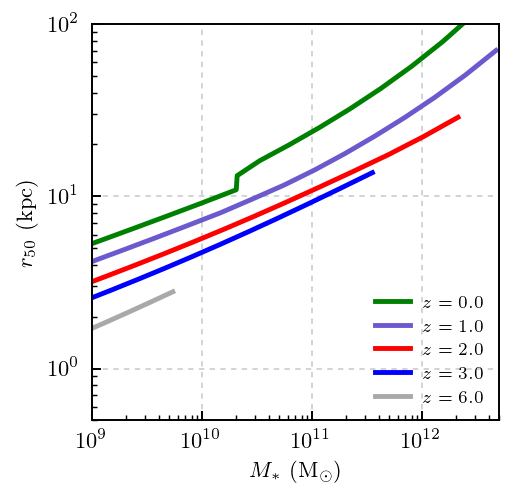

In [276]:
########################################################################

# PROBLEM 2.1.1. Plot r50-M*

########################################################################

### Reproduce result from HW5.


# plot r50-M*

fig = plt.figure(figsize=(3, 3))
plot_pretty()
plt.ylabel(r'$r_{50}\ \rm (kpc)$')
plt.xlabel(r'$M_{*}\ \rm (M_\odot)$')
ylims = [0.5,100.]
xlims = [1.e9, 5e12]
plt.xlim(xlims)
plt.ylim(ylims)
plt.xscale('log'); plt.yscale('log')
        
z_plot = np.array([0., 1.0, 2.0, 3.0, 6.0])
zcolors = ['green', 'slateblue', 'red', 'blue', 'darkgray']

# use existing grid calculation to calculate r50 at each point
model = 'Muratov15_3.6'
lMh  = windDict[model].lMhdomain
lMsi = windDict[model].logMsgrid
r50i = windDict[model].r50grid
for i, zplot in enumerate(z_plot):
    Msz = 10.**lMsi(np.log10(1.0+zplot),lMh)
    rhz = 10.**r50i(np.log10(1.0+zplot),lMh)
    tplot = cosmo.age(zplot)
    Msz = Msz * cosmo.h
    plt.plot(Msz, rhz, c=zcolors[i], lw=2.0, label=r'$z=%1.1f$'%zplot)

plt.legend(frameon=False, loc='lower right', fontsize=7)
plt.grid(linestyle=':', c='lightgray')
#plt.savefig('fig/msr50_nofbk.pdf',bbox_inches='tight')
plt.show()

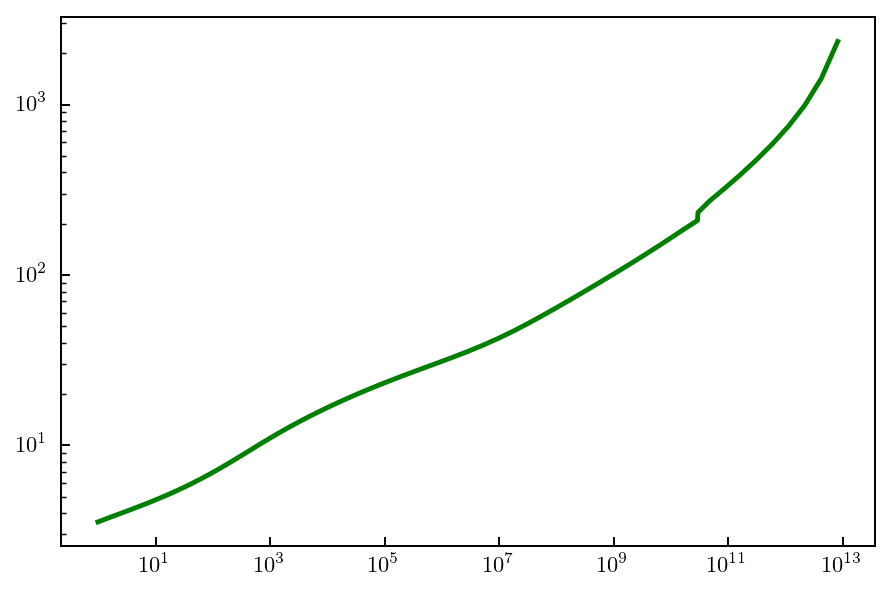

In [298]:
G = 6.67e-8 # grav. constant cgs

def R_d(r50):
    rd = r50/1.687
    return rd 

def v2_circ_disk(R, Mg, Ms, Rd, cosmo):
    from scipy.special import iv
    from scipy.special import kn
    R  = R*3.086e+21
    Rd = Rd*3.086e+21
    Mg = Mg*2.e33
    Ms = Ms*2.e33
    y = R/(2.*Rd)
    Sig0 = (Mg + Ms)/(2*np.pi*Rd**2)
    V2bar =4*np.pi*G*Sig0*Rd*y**2*(iv(0, y)*kn(0, y) - iv(1, y)*kn(1, y))
    return V2bar

def v2_circ_halo(R, Mh, cosmo, z):
    Mhh = Mh/cosmo.h
    c = concentration(Mhh, 'vir', z, model='diemer15')
    M200c, R200c, c200c = changeMassDefinition(Mhh, c, z, 'vir', '200c')
    M200 = M200c*2.e33/cosmo.h
    R200 = R200c*3.086e+21/cosmo.h
    R    = R*3.086e+21
    V2_200 = G*M200/R200
    V2_200/1.e5
    x = R/R200
    V2halo = V2_200/x*(np.log(1.+c*x) - c*x/(1.+c*x))/(np.log(1.+c) - c/(1.+c))
    return V2halo

def plot_TF_evo():
    return

lMh  = windDict[model].lMhdomain
lMhi = windDict[model].logMhgrid
lMgi = windDict[model].logMggrid
lMsi = windDict[model].logMsgrid
r50i = windDict[model].r50grid

z_plot = [0.0]
for i, zplot in enumerate(z_plot):
    Mhz = 10.**lMhi(np.log10(1.0+zplot),lMh)
    Mgz = 10.**lMgi(np.log10(1.0+zplot),lMh)
    Msz = 10.**lMsi(np.log10(1.0+zplot),lMh)
    rhz = 10.**r50i(np.log10(1.0+zplot),lMh) # r_50 returns in kpc (no h^-1)
    Rd  = R_d(rhz)
    R22 = 2.2*Rd
    v2d = v2_circ_disk(R22, Mgz, Msz, Rd, cosmo)
    v2h = v2_circ_halo(R22, Mhz, cosmo, zplot)
    v2tot = v2d + v2h
    v2tot = v2tot
    vtot  = np.sqrt(v2tot)/1.e5
    plt.plot(Msz, vtot, c=zcolors[i], lw=2.0, label=r'$z=%1.1f$'%zplot)

plt.xscale('log')
plt.yscale('log')

<b>(b) (10 points)</b> compare the model BTFR to the data in the recent compilation of <a href="http://adsabs.harvard.edu/abs/2016arXiv160202757B">Bradford et al. (2016)</a>. The data file is available in the usual place where I store data and scripts showing how to read the data is below. How well does the model match the observed relation? Discuss dependence on the wind modelling, as in a. 
 

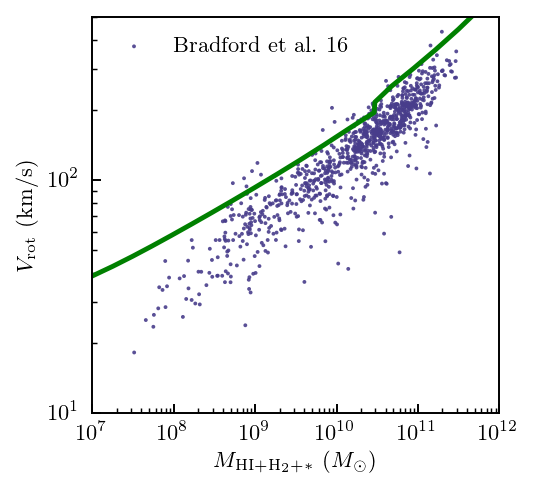

In [295]:
import astropy.io.fits as pyfits
from code.setup import data_home_dir
from code.plot_utils import plot_pretty
from matplotlib import pylab as plt
plot_pretty()

bf1 = pyfits.open(data_home_dir()+'figure_1_bradford_2016.fits')[1].data
# if you want to see what's in the fits table, uncomment
#bf1h = pyfits.open('data/figure_1_bradford_2016.fits')[1].header
#print bf1h

mbbar = bf1['MBARYON']
embar = bf1['MBARYON_ERR']
w20b = bf1['VW20I']
ew20b = bf1['VW20I_ERR']
#mbHI = np.log10(mbHI) + 0.1238; mbs = np.log10(mbs) + 9.0
mbbar += 0.1238 

plt.figure(figsize=(3.,3.))
plt.xscale('log'); plt.yscale('log')
plt.xlim([1.e7,1.e12]); plt.ylim([10.,500.])
plt.ylabel(r'$V_{\rm rot}\ \mathrm{(km/s)}$'); plt.xlabel(r'$M_{\rm HI+H_2+*}\ {(M_\odot)}$')
plt.scatter(10.**mbbar,w20b,marker='.',c='darkslateblue',s=10.,alpha=0.9,edgecolor='none', label=r'$\mathrm{Bradford\ et\ al.\ 16}$')

plt.legend(frameon=False,loc='upper left', fontsize=9)

z_plot = [0.0]
for i, zplot in enumerate(z_plot):
    Mhz = 10.**lMhi(np.log10(1.0+zplot),lMh)
    Mgz = 10.**lMgi(np.log10(1.0+zplot),lMh)
    Msz = 10.**lMsi(np.log10(1.0+zplot),lMh)
    rhz = 10.**r50i(np.log10(1.0+zplot),lMh) # r_50 returns in kpc (no h^-1)
    Rd  = R_d(rhz)
    R22 = 2.2*Rd
    v2d = v2_circ_disk(R22, Mgz, Msz, Rd, cosmo)
    v2h = v2_circ_halo(R22, Mhz, cosmo, zplot)
    v2tot = v2d + v2h
    v2tot = v2tot
    vtot  = np.sqrt(v2tot)/1.e5
    plt.plot(Msz, vtot, c=zcolors[i], lw=2.0, label=r'$z=%1.1f$'%zplot)

plt.xscale('log')
plt.yscale('log')

plt.show()

<b>3. Metallicity-stellar mass relation. (20 points)</b> The galaxy model tracks mass of metals produced by stars and so can be used to look at the metallicity-stellar mass relation. Compare evolution $Z/Z_\odot-M_*$ relations in the models with and without wind outflows. 

<b>(a) (10 points)</b> Can you match the observed $z=0$ correlation (see script plotting below) with the full model with outflows? What about evolution of $M_*-Z$ relation? The observed evolution of $Z-M_*$ relation was estimated by <a href="http://adsabs.harvard.edu/abs/2008A%26A...488..463M">Maiolino et al. (2008)</a>, as implemented in the function below. What is the effect of including gas outflow (winds) on the $Z-M_*$ relation? Does model relation match the observed evolution? How do results depend on the assumptions about mass loading factor? 

The script below plots $M_*-Z$ data for galaxies at $z=0$ all the way down to ultra-faint dwarfs (this is re-creation of Fig 1.20 in the notes) and also shows evolution of the relation at larger masses at higher $z$, as measured by <a href="http://adsabs.harvard.edu/abs/2008A%26A...488..463M">Maiolino et al. (2008)</a>. Compare your results in (a) and (b) above to these data. 

evolving mass grid...
done.
evolving mass grid...
done.
evolving mass grid...
done.
evolving mass grid...
done.


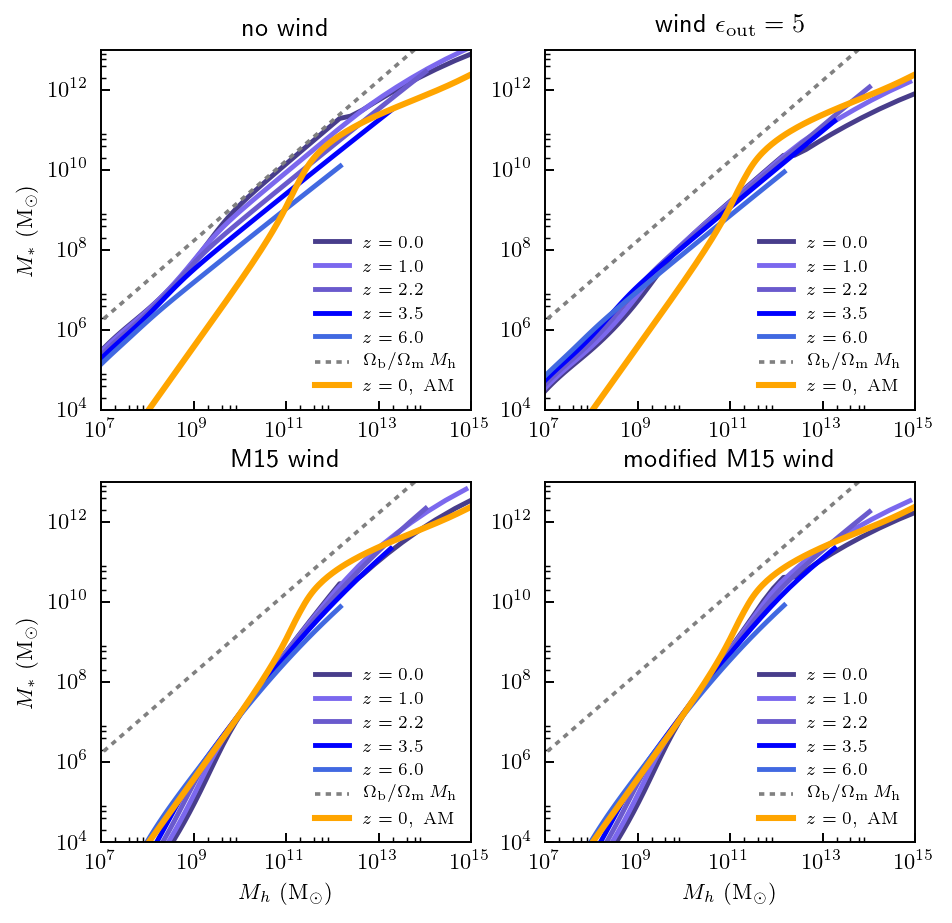

In [239]:
########################################################################

# PROBLEM 3.1.1. Calculate on mass grid

########################################################################


### Grid specifications

zmin = 0.
zmax = 30.
Nz = 81

Mhmin = 5.
Mhmax = 8.
Nm = 60


### Model specifications

# cosmology
my_cosmo = {'flat': True, 'H0': 70.0, 'Om0': 0.27, 'Ob0': 0.045714, 'sigma8': 0.82, 'ns': 0.96}
cosmo = cosmology.setCosmology('my_cosmo', my_cosmo)    

# metallicity floor of IGM due to early enrichment by Pop III stars
#Z_IGM =3.e-3 * 0.018
Zigm = 2.e-5

# star formation settings
sfrmodel = "gaslinear"  # another implemented option is gaslinear: SFR=Mgas/tau
tausfr = 2.0

# outflow settings
etaout = 0.0

### Now evolve the galaxy model on our mass, z grid for various wind 
### models.

windDict = {}
models = []
# no outflows
etaout = 0.0
windmodel = 'constload'
galgrid = gmodel_grid(gmodel = gmodel_wind, Nz=Nz, Nm=Nm, Z_IGM=Zigm, 
                            sfrmodel='gaslinear', tausf=tausfr, 
                            windmodel=windmodel, etawind=etaout, ac='off', 
                            cosmo=cosmo)
galgrid.compute_mass_grid()
windDict['{0}_{1:0.1f}'.format(windmodel, etaout)] = galgrid
models.append(model)
# constant mass loading factor = 5.0
etaout = 5.0
windmodel = 'constload'
galgrid = gmodel_grid(gmodel = gmodel_wind, Nz=Nz, Nm=Nm, Z_IGM=Zigm, 
                            sfrmodel='gaslinear', tausf=tausfr, 
                            windmodel=windmodel, etawind=etaout, ac='off', 
                            cosmo=cosmo)
galgrid.compute_mass_grid()
windDict['{0}_{1:0.1f}'.format(windmodel, etaout)] = galgrid
models.append(model)

# Muratov et al. 2015 mass loading factor
etaout = 3.6
windmodel = 'Muratov15'
galgrid = gmodel_grid(gmodel = gmodel_wind, Nz=Nz, Nm=Nm, Z_IGM=Zigm, 
                            sfrmodel='gaslinear', tausf=tausfr, 
                            windmodel=windmodel, etawind=etaout, ac='off', 
                            cosmo=cosmo)
galgrid.compute_mass_grid()
windDict['{0}_{1:0.1f}'.format(windmodel, etaout)] = galgrid
models.append(model)

# Muratov et al. 2015 mass loading factor with modification
etaout = 3.6
windmodel = 'Muratov15mod'
galgrid = gmodel_grid(gmodel = gmodel_wind, Nz=Nz, Nm=Nm, Z_IGM=Zigm, 
                            sfrmodel='gaslinear', tausf=tausfr, 
                            windmodel=windmodel, etawind=etaout, ac='off', 
                            cosmo=cosmo)
galgrid.compute_mass_grid()
windDict['{0}_{1:0.1f}'.format(windmodel, etaout)] = galgrid
models.append(model)

########################################################################

# PROBLEM 3.1.2. Plot M*-Mh relation(s)

########################################################################


### Sanity check to confirm that the wind models were successfully
### imported.

from code.setup import data_home_dir

fig, axs = plt.subplots(2, 2, figsize=(6, 6))
zplot = np.array([0., 1.0, 2.2, 3.5, 6.0])
zcolors = np.array(['darkslateblue', 'mediumslateblue', 'slateblue', 'blue', 'royalblue'])
titles = [r'no wind', r'wind $\epsilon_{\rm out}=5$', r'M15 wind', r'modified M15 wind']
models = ['constload_0.0','constload_5.0','Muratov15_3.6', 'Muratov15mod_3.6']
xlims = [1.e7, 1.e15]
ylims = [1.e4, 1.e13]

for ip, model in enumerate(models):
    axd = axs.flatten()[ip]
    if ip > 1:
        axd.set_xlabel(r'$M_h\ \rm (M_\odot)$')
    if ip == 0 or ip == 2:
        axd.set_ylabel(r'$M_{*}\ \rm (M_\odot)$')
    axd.set_xlim(xlims)
    axd.set_ylim(ylims)
    axd.set_xscale('log')
    axd.set_yscale('log')
    if ip == 3:
        legend = True
    else:
        legend = False 
    axd.set_title(titles[ip])
    windDict[model].plot_MsMh_evo(axd, zplot, zcolors, compare = True)
    #axd.legend()
#plt.savefig(savefig, bbox_inches='tight')

fig.show()


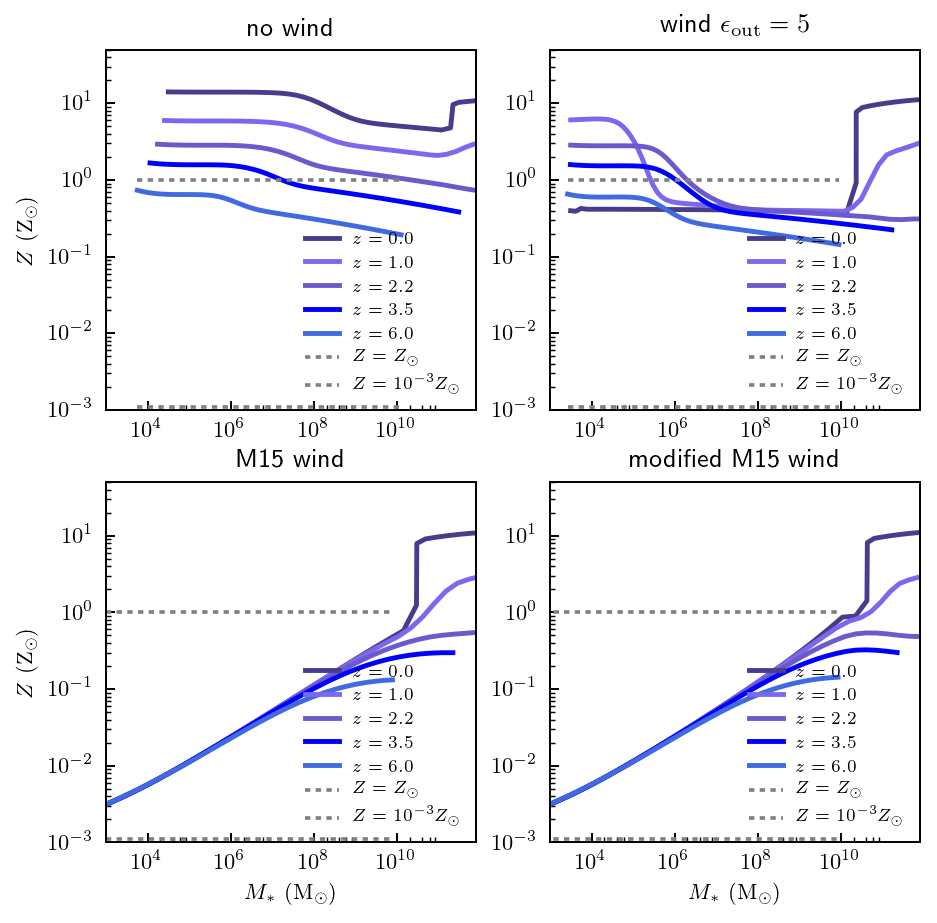

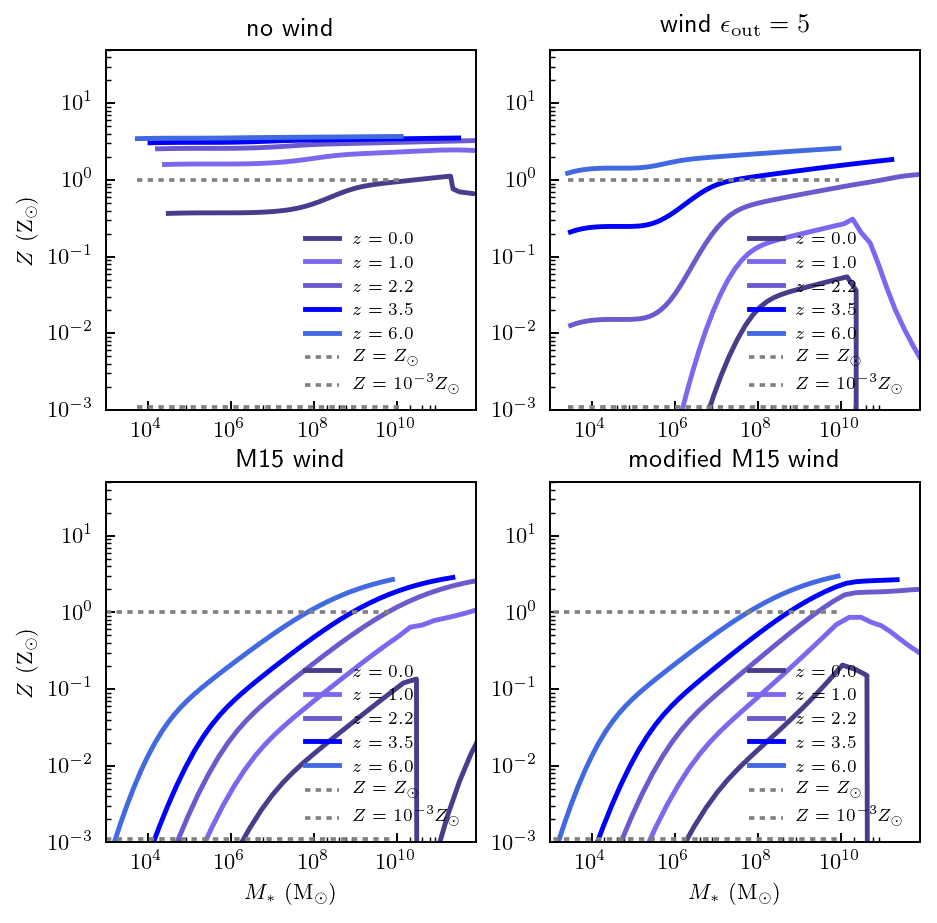

In [240]:
########################################################################

# PROBLEM 3.1.3. Plot Model Z-M* relation(s)

########################################################################


### Plot only the galaxy model evolution of Zg-M* 

fig, axs = plt.subplots(2, 2, figsize=(6, 6))
zplot = np.array([0., 1.0, 2.2, 3.5, 6.0])
zcolors = np.array(['darkslateblue', 'mediumslateblue', 'slateblue', 'blue', 'royalblue'])
titles = [r'no wind', r'wind $\epsilon_{\rm out}=5$', r'M15 wind', r'modified M15 wind']
models = ['constload_0.0','constload_5.0','Muratov15_3.6', 'Muratov15mod_3.6']


xlabel = r'$M_{{*}}\ \rm (M_\odot)$'
ylabel = r'$Z\ \rm (Z_\odot)$'
xlims = [1.e3, 8.e11]
ylims = [1.e-3,  50.]
for ip, model in enumerate(models):
    axd = axs.flatten()[ip]
    if ip > 1:
        axd.set_xlabel(xlabel)
    if ip == 0 or ip == 2:
        axd.set_ylabel(ylabel)
    axd.set_xlim(xlims)
    axd.set_ylim(ylims)
    axd.set_xscale('log')
    axd.set_yscale('log')
    if ip == 3:
        legend = True
    else:
        legend = False 
    axd.set_title(titles[ip])

    windDict[model].plot_ZgMs_evo(axd, zplot, zcolors)
    #axd.legend()
    
#plt.savefig(savefig, bbox_inches='tight')

fig.show()



### Plot the galaxy model evolution of Zs-M* 
fig, axs = plt.subplots(2, 2, figsize=(6, 6))
zplot = np.array([0., 1.0, 2.2, 3.5, 6.0])
zcolors = np.array(['darkslateblue', 'mediumslateblue', 'slateblue', 'blue', 'royalblue'])
titles = [r'no wind', r'wind $\epsilon_{\rm out}=5$', r'M15 wind', r'modified M15 wind']
models = ['constload_0.0','constload_5.0','Muratov15_3.6', 'Muratov15mod_3.6']


xlabel = r'$M_{{*}}\ \rm (M_\odot)$'
ylabel = r'$Z\ \rm (Z_\odot)$'
xlims = [1.e3, 8.e11]
ylims = [1.e-3,  50.]
for ip, model in enumerate(models):
    axd = axs.flatten()[ip]
    if ip > 1:
        axd.set_xlabel(xlabel)
    if ip == 0 or ip == 2:
        axd.set_ylabel(ylabel)
    axd.set_xlim(xlims)
    axd.set_ylim(ylims)
    axd.set_xscale('log')
    axd.set_yscale('log')
    if ip == 3:
        legend = True
    else:
        legend = False 
    axd.set_title(titles[ip])

    windDict[model].plot_ZsMs_evo(axd, zplot, zcolors)
    #axd.legend()
    
#plt.savefig(savefig, bbox_inches='tight')

fig.show()

$Z-M_*$ relations for several initial halo masses and redshifts. Legend is in bottom right figure and plotted curves are self-explanatory. 
<i> (top-left) </i> Without any outflows, the earliest star formation instantly enriches the galaxy to near solar metallicity. This enrichment continues with redshift to supersolar metallicities at $ z = 2.2 $, the peak of star formation in the universe. After $z = 2.2 $ the gradual decline in metallicity with redshift is purely due to dilution by accretion from the gaseous halo dominating over the production of metals by stars in the galaxy. This is why the decrease in metallicity picks up pace after $ z \sim 2.2 $, the peak of star formation in the universe. <i> (top-right) </i> We see an expected trend where low mass galaxies do not have sufficient pull to hold onto their outflowing material. Due to stellar outflows, we no longer see the turnaround of metal enrichment around $ z \sim 2 $. Instead, metallicity for low mass galaxies monotonically decreases with redshift as metal-enriched gas is blown out and replaced by gas in the halo (which I assume is less efficient at forming stars due to being at a higher temperature?). <i> (bottom) </i> The bottom two plots are identical for low masses, as they should be by design. We see that along lines of constant metallicity the stellar mass increases monotonically in time, so stellar enrichment, stellar outflows, and halo accretion all miraculously balance each other out. At very high masses and late times, we see drastic reduction in metallicity, likely due to huge outflows by AGN. 

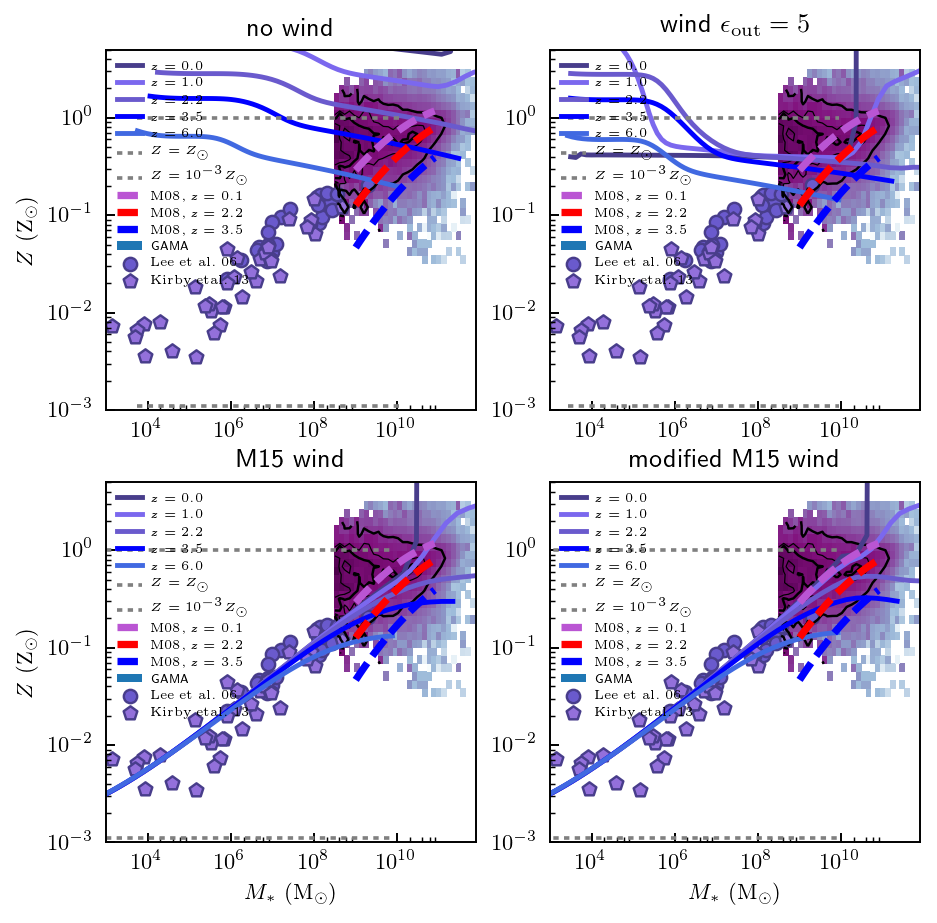

In [242]:
########################################################################

# PROBLEM 3.1.4. Compare Z-M* relation(s)

########################################################################


### Compare the Z-M* relation from 3.1.4. to the observed relation.

from code.setup import setup
from matplotlib import pylab as plt
from code.setup import data_home_dir

plot_pretty()


#
# plot observational trend from Maiolino
OHsol = 9.
    
def Zmaiolino08(lMs,lM0,K0):
    """
    best fit relation from table in Maiolino et al. 2008 using consistent Z calibration
    """
    return -0.0864*(lMs-lM0)**2 + K0

    
#
# plot GAMA data
#

def compute_inverse_Vmax(mags, zs, m_min=None, m_max=None, cosmomodel='WMAP9'):
    '''
    compute inverse Vmax for a given set of galaxy magnitudes and 
    redshifts, given magnitude limits m_min and m_max
    '''
    #from code.calc_kcor import calc_kcor 
    #ihz = [z>0.9]; zk = z; zk[ihz] = 0.9
    #kcorr = calc_kcor('r', zk, 'g - r', grm)
    from colossus.cosmology import cosmology
    # set cosmology to the best values from 9-year WMAP data
    cosmo = cosmology.setCosmology(cosmomodel)

    # compute luminosity and angular distances
    d_L = cosmo.luminosityDistance(zs)/cosmo.h

    # absolute magnitude in the r-band corrected for extinction
    Mabs = mags - 5.0*np.log10(d_L/1e-5) #- extm + 1.3*zs - kcorr; 

    # the sample magnitude limit is defined using Petrosian magnitude, so this is what we need to use to compute Vmax
    # we need to compute at what distance this galaxy would have limiting magnitude mlim, 
    # then compute Vmax using this distance, assuming flat cosmology (not a big deal at these low z): Vmax=d_M^3(z); d_M=d_L/(1+z) 
    d_Mmax = 1.e-5*np.power(10.,0.2*(m_max-Mabs))/(1.+zs)
    d_Mmin = 1.e-5*np.power(10.,0.2*(m_min-Mabs))/(1.+zs)

    vmaxi = 1.0/(np.power(d_Mmax,3.0) - np.power(d_Mmin,3.0))
    return vmaxi


def plot_GAMA(ax):
    def read_GAMA(fname):
        import astropy.io.fits as pyfits
        hdulist = pyfits.open(fname)
        return np.asarray(hdulist[1].data)
    
    data = read_GAMA(data_home_dir()+"GAMA_DR2_full.fits")
 
    z_min = 0.001
    z_max = 0.3
    m_min = 10.5
    m_max = 19.0
 
    data = data[data['GAL_MAG_R'] < m_max]; 
    data = data[data['GAL_MAG_R'] > m_min]; 
    data = data[data['Z_HELIO'] > z_min];   
    data = data[data['Z_HELIO'] < z_max]
 
    vmaxi = compute_inverse_Vmax(data['GAL_MAG_R'], data['Z_HELIO'], m_min, m_max)
    vmaxnorm = np.sum(vmaxi)
    vmaxi /= vmaxnorm
    Z = data['metal']/0.018 # normalize to solar according to Asplund et al. (2004)
    lZ = np.log10(Z)
    lMstar = data['logmstar']
    Mstar = np.power(10.,lMstar)
    clevs = np.linspace(0.2,0.95,4)
    
    import scipy.optimize as opt
    from matplotlib.colors import LogNorm
 
    def conf_interval(x, pdf, conf_level):
        return np.sum(pdf[pdf > x])-conf_level
 
    #
    H, xbins, ybins = np.histogram2d(lMstar, lZ, weights=vmaxi, bins=(np.linspace(8.5, 12., 31), np.linspace(-1.5, 1.0, 31)))
 
    H = np.rot90(H)
    H = np.flipud(H)
    Hmask = np.ma.masked_where(H==0,H)
    H = H/np.sum(H)        
             
    xbins = 10.**xbins; ybins = 10.**ybins
    X,Y = np.meshgrid(xbins[:-1],ybins[:-1]) 
 
    clevs = np.linspace(0.2,0.95,4)
    lvls = []
    for cld in clevs:  
        sig = opt.brentq( conf_interval, 0., 1., args=(H,cld) )  
        lvls.append(sig)
        
    #plt.scatter(10.**lMstar, 10.**lZ, c='m', s=0.85, alpha=0.5)
    ax.pcolor(X,Y,(Hmask),cmap=plt.cm.BuPu, norm = LogNorm(), label='GAMA',rasterized=True)
    ax.contour(X,Y,(H), linewidths=(1.0,0.5), colors='black', levels = lvls[::-1], norm = LogNorm(), extent = [xbins[0], xbins[-1], ybins[0], ybins[-1]])




fig, axs = plt.subplots(2, 2, figsize=(6, 6))
zplot = np.array([0., 1.0, 2.2, 3.5, 6.0])
zcolors = np.array(['darkslateblue', 'mediumslateblue', 'slateblue', 'blue', 'royalblue'])
titles = [r'no wind', r'wind $\epsilon_{\rm out}=5$', r'M15 wind', r'modified M15 wind']

xlabel = r'$M_{{*}}\ \rm (M_\odot)$'
ylabel = r'$Z\ \rm (Z_\odot)$'
xlims = [1.e3, 8.e11]
ylims = [1.e-3,  5.]
for ip, model in enumerate(models):
    axd = axs.flatten()[ip]
    if ip > 1:
        axd.set_xlabel(xlabel)
    if ip == 0 or ip == 2:
        axd.set_ylabel(ylabel)
    axd.set_xlim(xlims)
    axd.set_ylim(ylims)
    axd.set_xscale('log')
    axd.set_yscale('log')
    if ip == 3:
        legend = True
    else:
        legend = False 
    axd.set_title(titles[ip])

    windDict[model].plot_ZgMs_evo(axd, zplot, zcolors)    
    
    
    plot_GAMA(axd)
    # plot Mailino et al. (2008)
    maiozcolors = ['mediumorchid', 'red', 'blue', 'darkgray']
    zmaio = np.array([0.07,  2.2, 3.5])
    lM0 = np.array([11.8, 12.38, 12.76])
    K0 = np.array([9.04, 8.99, 8.79])
    nzplot = 3

    lMs = np.arange(9.0, 11.0, 0.1)
    for i, zm in enumerate(zmaio[:nzplot]): 
        Zmaio = Zmaiolino08(lMs, lM0[i], K0[i]) - OHsol + 0.1
        axd.plot(10.**lMs, 10.**Zmaio, '--', c=maiozcolors[i], lw=3.0, 
                 label=r'${\rm M08}, z=%.1f$'%zm)
    
    # plot Lee et al. 2006
    lMsL = np.linspace(5.5, 9.5, 100)
    lZLp, elZLp, lMsLp = np.loadtxt(data_home_dir()+"lee06.txt",
                                    usecols=(1,3,4),unpack=True)
    lZLp = lZLp - OHsol
    axd.scatter(10**lMsLp,10.**lZLp, s=30, marker='o', c='slateblue',
                edgecolor='darkslateblue', label=r'$\rm Lee\ et\ al.\ 06$')
    
    # plot Kirby et al. (2013)
    lLVk, elLVk, lZk, elZk  = np.loadtxt(data_home_dir()+"kirby13_tab4.txt",
                                         usecols=(4,5,6,7),unpack=True)
    axd.scatter(10**lLVk, 10.**lZk, s=35, marker='p', 
                c='mediumpurple', edgecolor='darkslateblue',
                label=r'$\rm Kirby\ et al.\ 13$')

    axd.legend(frameon=False, loc='upper left', scatterpoints=1, fontsize=5)
#plt.grid()
#plt.savefig('fig/MsZ.pdf', bbox_inches='tight')
fig.show()
#plt.savefig(savefig, bbox_inches='tight')

<b>(b) (10 points)</b> In the galaxy formation model described in <a href="http://adsabs.harvard.edu/abs/2012ApJ...753...16K">Krumholz & Dekel (2012)</a>, the authors introduce an ingredient summarized in their eq. 22, which crudely models the results of simulations of winds from isolated galaxies by <a href="http://adsabs.harvard.edu/abs/1999ApJ...513..142M">Mac Low & Ferrara (1999)</a>, which showed that winds out of smaller mass galaxies carried more metals with them (i.e., the wind metallicity depends on galaxy mass). Implement this ingredient in the $M_Z$ evolution equation - i.e., eq 23 in KD13 and function <tt>zeta</tt> in the galaxy model class. How does this change the predicted $M_*-Z$ relation? (5 points)

In [243]:
class gmodel_zeta(gmodel_wind):
    def zeta(self):
        '''
        Uses Krumholz & Dekel (2012) prescription for metallicity of SNe
        outflows.
        output: fraction of newly produced metals removed by SNe in outflows.
        '''
        zetalow = 0.9
        Mret = 0.3
        zeta = zetalow*np.exp(-self.Mh/(Mret*1.e12))
        return zeta
    
    def dMZdt(self, Mcurrent, t):
        dummy = ( self.Z_IGM*self.Mg_in(t) + 
                 (self.yZ*self.Rloss1*(1.-self.zeta()) - 
                 (self.Rloss1 + self.eps_out())*self.MZ/(self.Mg))*self.SFR(t)
                )
        return dummy
    

########################################################################

# PROBLEM 3.1.5. Calculate on mass grid

########################################################################


### Grid specifications

zmin = 0.
zmax = 30.
Nz = 81

Mhmin = 5.
Mhmax = 8.
Nm = 60


### Model specifications

# cosmology
my_cosmo = {'flat': True, 'H0': 70.0, 'Om0': 0.27, 'Ob0': 0.045714, 'sigma8': 0.82, 'ns': 0.96}
cosmo = cosmology.setCosmology('my_cosmo', my_cosmo)    

# metallicity floor of IGM due to early enrichment by Pop III stars
#Z_IGM =3.e-3 * 0.018
Zigm = 2.e-5

# star formation settings
sfrmodel = "gaslinear"  # another implemented option is gaslinear: SFR=Mgas/tau
tausfr = 2.0

# outflow settings
etaout = 0.0

### Now evolve the galaxy model on our mass, z grid for various wind 
### models.

zetaDict = {}
zetamodels = []
# no outflows
etaout = 1.0
windmodel = 'constload'
galgrid = gmodel_grid(gmodel = gmodel_zeta, Nz=Nz, Nm=Nm, Z_IGM=Zigm, 
                            sfrmodel='gaslinear', tausf=tausfr, 
                            windmodel=windmodel, etawind=etaout, ac='off', 
                            cosmo=cosmo)
galgrid.compute_mass_grid()
zetaDict['{0}_{1:0.1f}'.format(windmodel, etaout)] = galgrid
zetamodels.append(model)
# constant mass loading factor = 5.0
etaout = 5.0
windmodel = 'constload'
galgrid = gmodel_grid(gmodel = gmodel_zeta, Nz=Nz, Nm=Nm, Z_IGM=Zigm, 
                            sfrmodel='gaslinear', tausf=tausfr, 
                            windmodel=windmodel, etawind=etaout, ac='off', 
                            cosmo=cosmo)
galgrid.compute_mass_grid()
zetaDict['{0}_{1:0.1f}'.format(windmodel, etaout)] = galgrid
zetamodels.append(model)

# Muratov et al. 2015 mass loading factor
etaout = 3.6
windmodel = 'Muratov15'
galgrid = gmodel_grid(gmodel = gmodel_zeta, Nz=Nz, Nm=Nm, Z_IGM=Zigm, 
                            sfrmodel='gaslinear', tausf=tausfr, 
                            windmodel=windmodel, etawind=etaout, ac='off', 
                            cosmo=cosmo)
galgrid.compute_mass_grid()
zetaDict['{0}_{1:0.1f}'.format(windmodel, etaout)] = galgrid
zetamodels.append(model)

# Muratov et al. 2015 mass loading factor with modification
etaout = 3.6
windmodel = 'Muratov15mod'
galgrid = gmodel_grid(gmodel = gmodel_zeta, Nz=Nz, Nm=Nm, Z_IGM=Zigm, 
                            sfrmodel='gaslinear', tausf=tausfr, 
                            windmodel=windmodel, etawind=etaout, ac='off', 
                            cosmo=cosmo)
galgrid.compute_mass_grid()
zetaDict['{0}_{1:0.1f}'.format(windmodel, etaout)] = galgrid
zetamodels.append(model)

evolving mass grid...
done.
evolving mass grid...
done.
evolving mass grid...
done.
evolving mass grid...
done.


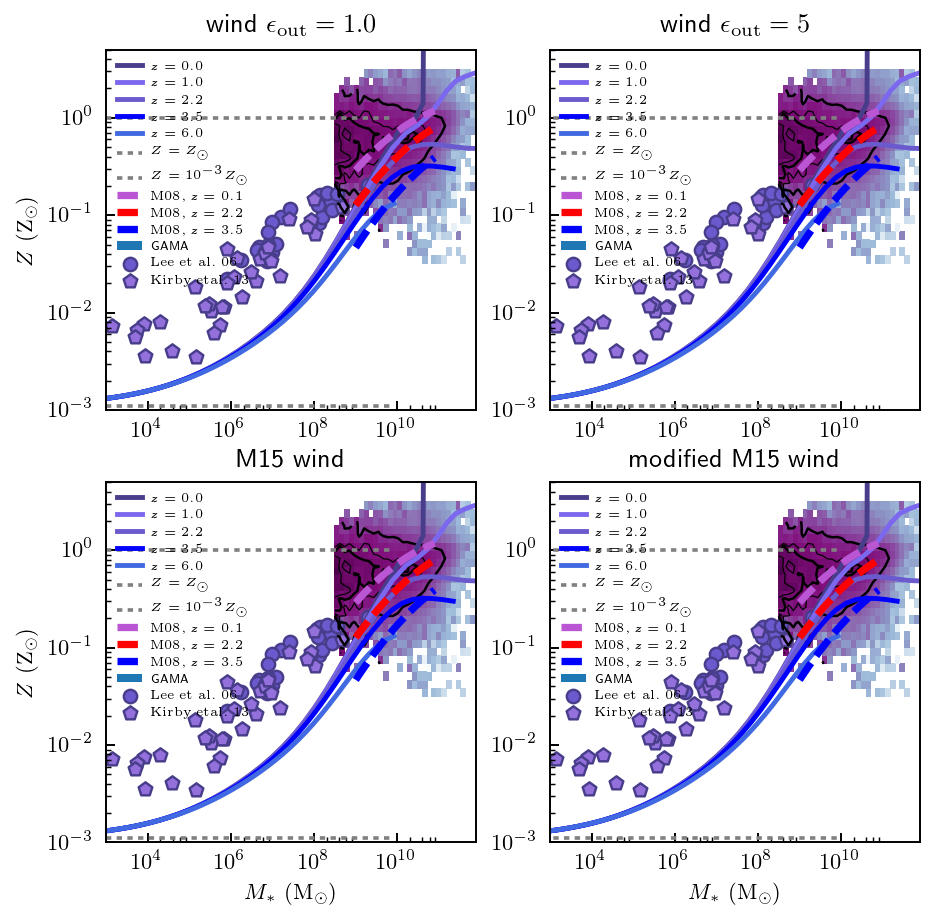

In [244]:
########################################################################

# PROBLEM 3.1.6. Compare Z-M* relation(s)

########################################################################


### Compare the Z-M* relation from 3.1.4. to the observed relation.

from code.setup import setup
from matplotlib import pylab as plt
from code.setup import data_home_dir

plot_pretty()


#
# plot observational trend from Maiolino
OHsol = 9.
    

fig, axs = plt.subplots(2, 2, figsize=(6, 6))
zplot = np.array([0., 1.0, 2.2, 3.5, 6.0])
zcolors = np.array(['darkslateblue', 'mediumslateblue', 'slateblue', 'blue', 'royalblue'])
titles = [r'wind $\epsilon_{\rm out}=1.0$', r'wind $\epsilon_{\rm out}=5$', r'M15 wind', r'modified M15 wind']

xlabel = r'$M_{{*}}\ \rm (M_\odot)$'
ylabel = r'$Z\ \rm (Z_\odot)$'
xlims = [1.e3, 8.e11]
ylims = [1.e-3,  5.]
for ip, model in enumerate(zetamodels):
    axd = axs.flatten()[ip]
    if ip > 1:
        axd.set_xlabel(xlabel)
    if ip == 0 or ip == 2:
        axd.set_ylabel(ylabel)
    axd.set_xlim(xlims)
    axd.set_ylim(ylims)
    axd.set_xscale('log')
    axd.set_yscale('log')
    if ip == 3:
        legend = True
    else:
        legend = False 
    axd.set_title(titles[ip])

    zetaDict[model].plot_ZgMs_evo(axd, zplot, zcolors)    
    
    
    plot_GAMA(axd)
    # plot Mailino et al. (2008)
    maiozcolors = ['mediumorchid', 'red', 'blue', 'darkgray']
    zmaio = np.array([0.07,  2.2, 3.5])
    lM0 = np.array([11.8, 12.38, 12.76])
    K0 = np.array([9.04, 8.99, 8.79])
    nzplot = 3

    lMs = np.arange(9.0, 11.0, 0.1)
    for i, zm in enumerate(zmaio[:nzplot]): 
        Zmaio = Zmaiolino08(lMs, lM0[i], K0[i]) - OHsol + 0.1
        axd.plot(10.**lMs, 10.**Zmaio, '--', c=maiozcolors[i], lw=3.0, 
                 label=r'${\rm M08}, z=%.1f$'%zm)
    
    # plot Lee et al. 2006
    lMsL = np.linspace(5.5, 9.5, 100)
    lZLp, elZLp, lMsLp = np.loadtxt(data_home_dir()+"lee06.txt",
                                    usecols=(1,3,4),unpack=True)
    lZLp = lZLp - OHsol
    axd.scatter(10**lMsLp,10.**lZLp, s=30, marker='o', c='slateblue',
                edgecolor='darkslateblue', label=r'$\rm Lee\ et\ al.\ 06$')
    
    # plot Kirby et al. (2013)
    lLVk, elLVk, lZk, elZk  = np.loadtxt(data_home_dir()+"kirby13_tab4.txt",
                                         usecols=(4,5,6,7),unpack=True)
    axd.scatter(10**lLVk, 10.**lZk, s=35, marker='p', 
                c='mediumpurple', edgecolor='darkslateblue',
                label=r'$\rm Kirby\ et al.\ 13$')

    axd.legend(frameon=False, loc='upper left', scatterpoints=1, fontsize=5)
#plt.grid()
#plt.savefig('fig/MsZ.pdf', bbox_inches='tight')
fig.show()
#plt.savefig(savefig, bbox_inches='tight')

<b>4. (20 points) Galactic outflows and effective yield.</b> A useful concept, which emerges from simple chemical evolution models described in <a href="https://github.com/a-kravtsov/a304s17/blob/master/ex10_galaxy_formation_model.ipynb">ex10</a> notebook, is the <i>effective yield</i>, $y_{\rm eff}$. It is defined as $y_{\rm eff}=Z/\ln(1/f_{\rm gas})$, where $Z$ is the mass fraction of heavy elements  in the gas and $f_{\rm gas}\equiv M_{\rm gas}/(M_{\rm gas}+M_*)$ is the gas mass fraction in the system. Read the chemical evolution model description in the second half of the <a href="https://github.com/a-kravtsov/a304s17/blob/master/ex10_galaxy_formation_model.ipynb">ex10</a> notebook on how this quantity comes about and why it is related to chemical evolution models. 

Briefly, if galaxy was a closed system, the effective yield would be driven to the true yield of a stellar population set as <tt>y_Z</tt> in the galaxy model (for a Chabrier IMF it is $y_{\rm Z}\approx 0.07$). However, in the presence of outflows, yield would be lower than the true yield. Thus, $y_{\rm eff}$ is a diagnostics that outflows operate in galaxies. 

<b>(a) (10 points)</b> Plot $y_{\rm eff}$ as a function of $M_*$ for model without outflows, for model with outflows but constant $\epsilon_{\rm out}$, and with mass-dependent outflow metallicity of Muratov et al. (2015) or something close. How does effective yield of galaxies change in these models?

In [257]:
########################################################################

# PROBLEM 4.1.1. Calculate on mass grid

########################################################################

### Model specifications

# cosmology
my_cosmo = {'flat': True, 'H0': 70.0, 'Om0': 0.27, 'Ob0': 0.045714, 'sigma8': 0.82, 'ns': 0.96}
cosmo = cosmology.setCosmology('my_cosmo', my_cosmo)    

# metallicity floor of IGM due to early enrichment by Pop III stars
#Z_IGM =3.e-3 * 0.018
Zigm = 2.e-5

# star formation settings
sfrmodel = "gaslinear"  # another implemented option is gaslinear: SFR=Mgas/tau
tausfr = 2.0

# outflow settings
etaout = 0.0

### Now evolve the galaxy model on our mass, z grid for various wind 
### models.

zetaDict = {}
zetamodels = []
# no outflows
etaout = 0.0
windmodel = 'constload'
galgrid = gmodel_grid(gmodel = gmodel_zeta, Nz=Nz, Nm=Nm, Z_IGM=Zigm, 
                            sfrmodel='gaslinear', tausf=tausfr, 
                            windmodel=windmodel, etawind=etaout, ac='off', 
                            cosmo=cosmo)
galgrid.compute_mass_grid()
zetaDict['{0}_{1:0.1f}'.format(windmodel, etaout)] = galgrid
zetamodels.append(model)
# constant mass loading factor = 5.0
etaout = 5.0
windmodel = 'constload'
galgrid = gmodel_grid(gmodel = gmodel_zeta, Nz=Nz, Nm=Nm, Z_IGM=Zigm, 
                            sfrmodel='gaslinear', tausf=tausfr, 
                            windmodel=windmodel, etawind=etaout, ac='off', 
                            cosmo=cosmo)
galgrid.compute_mass_grid()
zetaDict['{0}_{1:0.1f}'.format(windmodel, etaout)] = galgrid
zetamodels.append(model)

# Muratov et al. 2015 mass loading factor
etaout = 3.6
windmodel = 'Muratov15'
galgrid = gmodel_grid(gmodel = gmodel_zeta, Nz=Nz, Nm=Nm, Z_IGM=Zigm, 
                            sfrmodel='gaslinear', tausf=tausfr, 
                            windmodel=windmodel, etawind=etaout, ac='off', 
                            cosmo=cosmo)
galgrid.compute_mass_grid()
zetaDict['{0}_{1:0.1f}'.format(windmodel, etaout)] = galgrid
zetamodels.append(model)

# Muratov et al. 2015 mass loading factor with modification
etaout = 3.6
windmodel = 'Muratov15mod'
galgrid = gmodel_grid(gmodel = gmodel_zeta, Nz=Nz, Nm=Nm, Z_IGM=Zigm, 
                            sfrmodel='gaslinear', tausf=tausfr, 
                            windmodel=windmodel, etawind=etaout, ac='off', 
                            cosmo=cosmo)
galgrid.compute_mass_grid()
zetaDict['{0}_{1:0.1f}'.format(windmodel, etaout)] = galgrid
zetamodels.append(model)

evolving mass grid...
done.
evolving mass grid...
done.
evolving mass grid...
done.
evolving mass grid...
done.


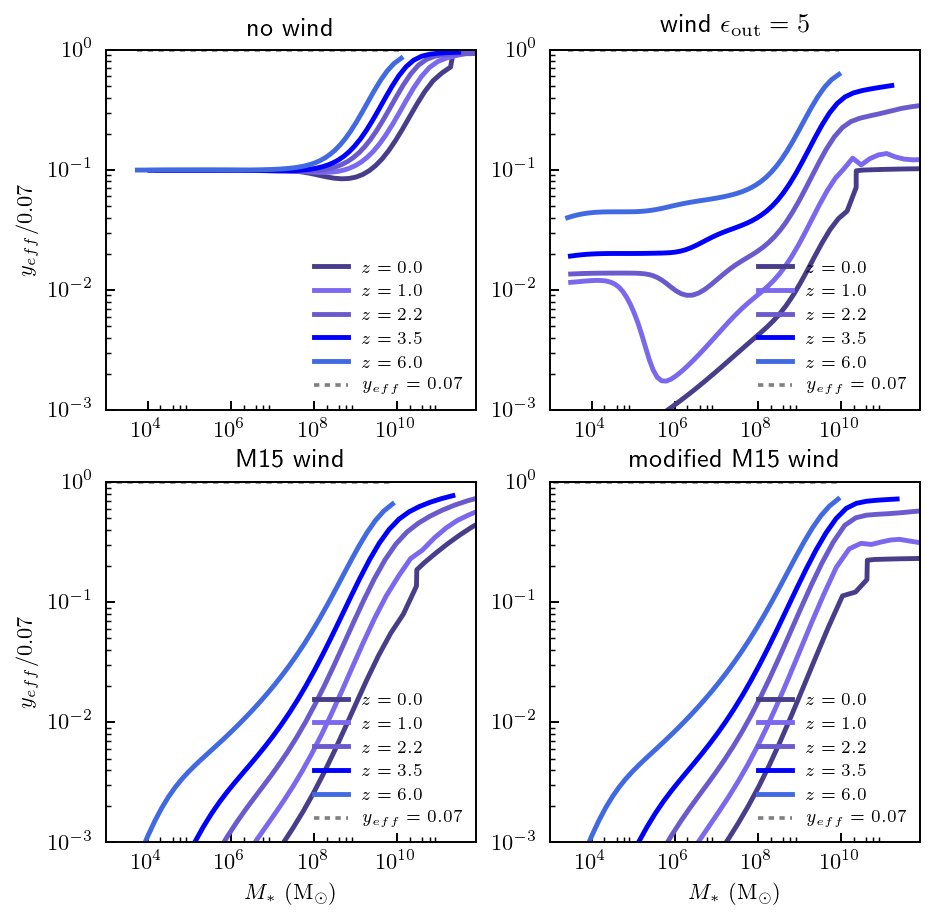

In [259]:
### Plot the galaxy model evolution of Zs-M* 

fig, axs = plt.subplots(2, 2, figsize=(6, 6))
zplot = np.array([0., 1.0, 2.2, 3.5, 6.0])
zcolors = np.array(['darkslateblue', 'mediumslateblue', 'slateblue', 'blue', 'royalblue'])
titles = [r'no wind', r'wind $\epsilon_{\rm out}=5$', r'M15 wind', r'modified M15 wind']
models = ['constload_0.0','constload_5.0','Muratov15_3.6', 'Muratov15mod_3.6']


xlabel = r'$M_{{*}}\ \rm (M_\odot)$'
ylabel = r'$y_{{eff}}/0.07$'
xlims = [1.e3, 8.e11]
ylims = [1.e-3,  1.]
for ip, model in enumerate(models):
    axd = axs.flatten()[ip]
    if ip > 1:
        axd.set_xlabel(xlabel)
    if ip == 0 or ip == 2:
        axd.set_ylabel(ylabel)
    axd.set_xlim(xlims)
    axd.set_ylim(ylims)
    axd.set_xscale('log')
    axd.set_yscale('log')
    if ip == 3:
        legend = True
    else:
        legend = False 
    axd.set_title(titles[ip])
    zetaDict[model].plot_ygMs_evo(axd, zplot, zcolors)
    #axd.legend()
    
#plt.savefig(savefig, bbox_inches='tight')

fig.show()

In the highest mass galaxies, the potential is sufficiently deep that it behaves just as a closed box scenario regardless of feedback processes, so $ y_{eff} \rightarrow y_{IMF,Chab} = 0.07 $. We see that, as expected, losses due to to wind dominate $y_{eff}$ at low stellar masses.

<b>(b) (10 points)</b> Estimate the fraction of metals retained within stars and gas of the galaxy. Plot the retained fraction as a function of galaxy stellar mass and compare with the observed trend discussed in for the model without wind and with the wind <a href="http://adsabs.harvard.edu/abs/2014ApJ...786...54P">Peeples et al. (2014)</a>. How do you interpret the results in terms of the galaxy formation processes?

<b> 5. (10 points) Metallicity distribution of stars in Milky Way-sized systems.</b> Given that metallicity is tracked in the model as a function of time, you can calculate the distribution of metallicities for stars formed in a given model. 

Construct such distribution for a Milky Way sized system ($M_h=10^{12}\ M_\odot$ at $z=0$) in the same models as before: no outflows, outflows of constant metallicity, outflows of varying metallicity as in 3b. How does distribution of metallicities vary for these models? Describe the overall distribution of metallicities and how it compares to the metallicity of the Milky Way disk stars, which you can find in Fig 2 and Table 2 of <a href="http://adsabs.harvard.edu/abs/2012MNRAS.422.1489W">Woolf & West (2012)</a>, for example. Also, compare to the predictions of the closed-box model, which you can find in <a href="https://github.com/a-kravtsov/a304s17/blob/master/ex10_galaxy_formation_model.ipynb">ex10</a> notebook. 

Discuss the difference of this model from the actual model calculation and the observed metallicity distribution in the Milky Way in the context of the so-called G-dwarf "problem" (see <a href="https://github.com/a-kravtsov/a304s17/blob/master/ex10_galaxy_formation_model.ipynb">ex10</a> notebook).

<b>6. Galaxy evolution and galaxy morphology and color. (10 points) </b> Previously in this class we have discussed criterion for bar instability. Estimate this criterion for galaxies forming in halos of different mass in the galaxy formation model with and without wind, using model for the rotation curve similar to that constructed in exercise 2 above. 

<b>(a) (7 points)</b> How does this criterion depend on time and galaxy stellar mass. Suppose violent bar instability leads to formation of massive bulges or even transforms galaxies from disks to lenticular systems. 

<b>(b) (3 points)</b> What can you infer about the prevalence of galaxies of different morphologies? How does this compare to your measurements of stellar mass functions for galaxies of different morphologies. 

<b>7. Galaxy star formation histories. (15 points) </b>

<b>(a) (10 points)</b> Extract a few star formation histories for galaxies of different representative stellar masses predicted by the galaxy formation model we've constructed, as well as their metallicities as a function of time for model with no winds and model with the Muratov et al. (2015) winds. Using these histories and assuming Chabrier IMF compute the evolution of color as a function of time for these galaxies using <tt>EzGal</tt> code, as shown in <a href="https://github.com/a-kravtsov/a304s17/blob/master/ex03_stellar_population_synthesis.ipynb">ex03</a> notebook. How can you interpret the observed distribution of colors using these results?  

<b>(a) (5 points)</b> Compare the star formation histories in the model with the M15 winds for different stellar masses with the functional forms often assumed when star formation histories are modelled in observations, which are described in the <a href="https://github.com/a-kravtsov/a304s17/blob/master/ex03_stellar_population_synthesis.ipynb">ex03 notebook</a>. How well do these analytic models describe the star formation histories described by the model?

<b>8. $\dot{M}_\star-M_\star-Z$ correlation of galaxies (10 points)</b>

Observed galaxies exhibit a strong correlation between star formation rate, stellar mass, and metallicity, which some astronomers have dubbled "the fundamental relation" (see <a href="http://adsabs.harvard.edu/abs/2010MNRAS.408.2115M">Mannucci et al. 2010</a>).  

<b>(a) (5 points)</b> Examine how galaxies in our model with and without winds evolve in the 3D space of these parameters. Discuss possible qualitative explanation for the correlations and the evolution you see. 

<b>(b) (5 points)</b> Compare predictions of models with and without winds at $z=0$ to the observed $\dot{M}_\star-M_\star-Z$ correlation of galaxies in the GAMA survey. Below I include a script showing you how to access these quantities in the survey. You can either compare in 2D projections ($M_\star-Z$, $\dot{M}_\star-M_\star$) or plot predictions and observations in a 3D plot, using <a href="https://matplotlib.org/mpl_toolkits/mplot3d/tutorial.html">mplot3d</a> routines of matplotlib.

In [ ]:
from code.setup import data_home_dir

def read_GAMA(fname):
    import pyfits
    hdulist = pyfits.open(fname)
    return np.asarray(hdulist[1].data)
    
data = read_GAMA(data_home_dir()+"GAMA_DR2_full.fits")
 
z_min = 0.001
z_max = 0.3
m_min = 10.5
m_max = 19.0
 
data = data[data['GAL_MAG_R'] < m_max]; 
data = data[data['GAL_MAG_R'] > m_min]; 
data = data[data['Z_HELIO'] > z_min];   
data = data[data['Z_HELIO'] < z_max]
 
Z = data['metal']/0.018 # normalize to solar metallicity
lZ = np.log10(Z)
lMstar = data['logmstar']
Mstar = np.power(10.,lMstar)
sfr = data['SFR']
lsfr = np.log10(sfr)


# Tinkering with code

evolving mass grid...
done.


(<scipy.interpolate.interpolate.interp2d at 0x1141380d0>,
 <scipy.interpolate.interpolate.interp2d at 0x117c14310>)

evolving mass grid...
done.


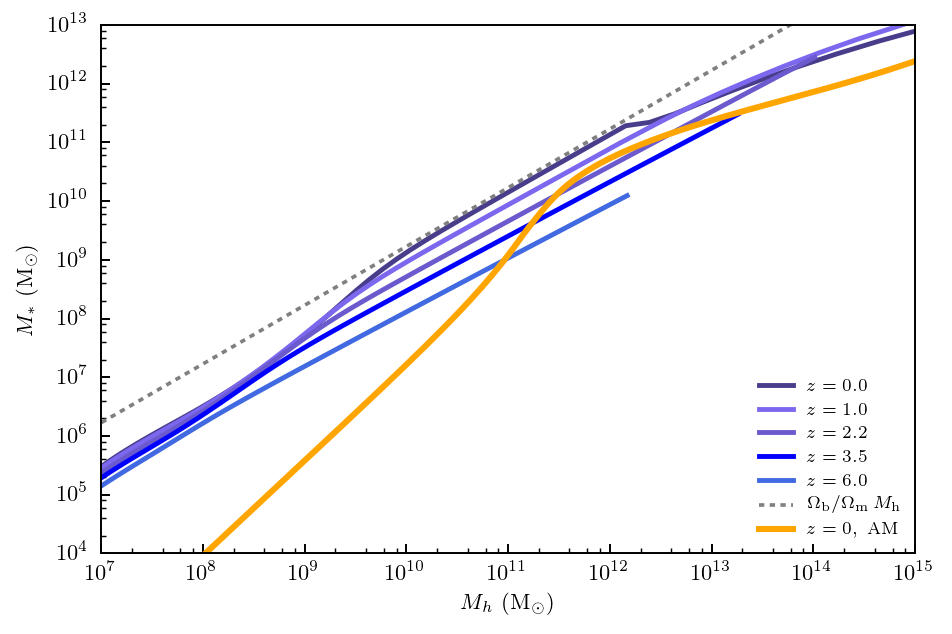

In [126]:
### Grid specifications

zmin = 0.
zmax = 30.
Nz = 81

Mhmin = 5.
Mhmax = 8.
Nm = 60


### Model specifications

# cosmology
my_cosmo = {'flat': True, 'H0': 70.0, 'Om0': 0.27, 'Ob0': 0.045714, 'sigma8': 0.82, 'ns': 0.96}
cosmo = cosmology.setCosmology('my_cosmo', my_cosmo)    

# metallicity floor of IGM due to early enrichment by Pop III stars
#Z_IGM =3.e-3 * 0.018
Zigm = 2.e-5

# star formation settings
sfrmodel = "gaslinear"  # another implemented option is gaslinear: SFR=Mgas/tau
tausfr = 2.0

# outflow settings
etaout = 0.0

# initialize new grid object. Convenient!
zetagrid = gmodel_grid(gmodel = gmodel_zeta, Nz=Nz, Nm=Nm, Z_IGM=Zigm, 
                            sfrmodel='gaslinear', tausf=tausfr, 
                            windmodel='constload', etawind=etaout, ac='off', 
                            cosmo=cosmo)

zetagrid.compute_mass_grid()

fig, ax = plt.subplots()
zetagrid.plot_MsMh_evo(ax, zplot, zcolors, compare = True)
ax.set_xlabel(r'$M_h\ \rm (M_\odot)$')
ax.set_ylabel(r'$M_{*}\ \rm (M_\odot)$')
ax.set_xlim(1.e7,1.e15)
ax.set_ylim(1.e4,1.e13)
ax.set_xscale('log')
ax.set_yscale('log')



Success!!

In [ ]:
fig, axs = plt.subplots(2,2, figsize=(6, 6))
zplot = np.array([0., 1.0, 2.2, 3.5, 6.0])
zcolors = np.array(['darkslateblue', 'mediumslateblue', 'slateblue', 
                    'blue', 'royalblue'])
titles = [r'\( \epsilon_{\rm out}=1.0 \)', r'$\epsilon_{\rm out}=5$', 
          r'M15 wind', r'modified M15 wind']
#xlims = [1.e7, 1.e15]
#ylims = [1.e4, 1.e13]

xlabel = r'$M_{{*}}\ \rm (M_\odot)$'
ylabel = r'$Z\ \rm (Z_\odot)$'
xlims = [1.e3, 8.e11]
ylims = [1.e-4,  5.]

for ip, (axd, modelname) in enumerate(zip(axs.flatten(), lMdict)):
    if ip > 1:
        axd.set_xlabel(xlabel)
    if ip == 0 or ip == 2:
        axd.set_ylabel(ylabel)
    axd.set_xlim(xlims)
    axd.set_ylim(ylims)
    axd.set_xscale('log')
    axd.set_yscale('log')
    if ip == 3:
        legend = True
    else:
        legend = False 
    axd.set_title(titles[ip])
    lMdicti = lMdict[modelname]
    lMZi = lMdicti['logMZ']
    lMgi = lMdicti['logMg']
    lMsi = lMdicti['logMs']
    plot_ZMs_evo(axd, lMZi, lMgi, lMsi, lMh, zplot, zcolors, 
                 legend = legend, grid = True)
    #axd.legend()
    plot_GAMA(axd)
    
    # plot Mailino et al. (2008)
    maiozcolors = ['mediumorchid', 'red', 'blue', 'darkgray']
    zmaio = np.array([0.07,  2.2, 3.5])
    lM0 = np.array([11.8, 12.38, 12.76])
    K0 = np.array([9.04, 8.99, 8.79])
    nzplot = 3

    lMs = np.arange(9.0, 11.0, 0.1)
    for i, zm in enumerate(zmaio[:nzplot]): 
        Zmaio = Zmaiolino08(lMs, lM0[i], K0[i]) - OHsol + 0.1
        axd.plot(10.**lMs, 10.**Zmaio, '--', c=maiozcolors[i], lw=3.0, 
                 label=r'${\rm M08}, z=%.1f$'%zm)
    
    # plot Lee et al. 2006
    lMsL = np.linspace(5.5, 9.5, 100)
    lZLp, elZLp, lMsLp = np.loadtxt(data_home_dir()+"lee06.txt",
                                    usecols=(1,3,4),unpack=True)
    lZLp = lZLp - OHsol
    axd.scatter(10**lMsLp,10.**lZLp, s=30, marker='o', c='slateblue',
                edgecolor='darkslateblue', label=r'$\rm Lee\ et\ al.\ 06$')
    
    # plot Kirby et al. (2013)
    lLVk, elLVk, lZk, elZk  = np.loadtxt(data_home_dir()+"kirby13_tab4.txt",
                                         usecols=(4,5,6,7),unpack=True)
    axd.scatter(10**lLVk, 10.**lZk, s=35, marker='p', 
                c='mediumpurple', edgecolor='darkslateblue',
                label=r'$\rm Kirby\ et al.\ 13$')

    axd.legend(frameon=False, loc='upper left', scatterpoints=1, fontsize=5)
#plt.grid()
#plt.savefig('fig/MsZ.pdf', bbox_inches='tight')
fig.show()
#plt.savefig(savefig, bbox_inches='tight')

In [ ]:
### stupid idea to put all evolution relations in one function
### wastefully general; no one wants to input a string every time....

def plot_evo(ax, lMhplot, zplot, zcolors, kind, legend = True, 
             grid=False):
    '''
    Convenience function that can be built into galaxy_model as a 
    diagnostics method. 
    Parameters
    ----------
    lMdicti (dict)    : Contains all the mass splines calculated
                        with computer_mass_grid() with the keys
                        ['logMh', 'logMg', 'logMs', 'logMZ'].
    
    kind (str)        : Type of evolution relation to plot. Available
                        relations currently include: ['Mh-Ms', 'Zs-Ms',
                        'Zg-Ms', 'yeff-Ms'].
                        
    lMhplot (np array): array of starting halo masses for which you
                        wish to plot. Should be same as domain of
                        your galaxy model calculation.
                          
    '''
    # unpack the individual mass splines
    #lMZi = lMdicti['logMZ']
    #lMgi = lMdicti['logMg']
    #lMsi = lMdicti['logMs']
    if kind == 'Ms-Mh':
        
    if kind == 'Zs-Ms':
        for i, z_plot in enumerate(zplot):
            MZz = 10.**lMZi(np.log10(1.0+z_plot),lMhplot)
            Mgz = 10.**lMgi(np.log10(1.0+z_plot),lMhplot)
            Msz = 10.**lMsi(np.log10(1.0+z_plot),lMhplot)
            Zz  = MZz/(Msz)/0.018
            ax.plot(Msz, Zz, c=zcolors[i], lw=2., label=r'$z=%1.1f$'%z_plot)

        # plot solar metallicity line, Z = 0.018
        Zsolars = np.ones_like(Msz)
        ax.plot(Msz, Zsolars, ':', c='gray', lw=1.5, label=r'$Z = Z_\odot $')

        # plot ZIGM line at Z = 2x10^-5, or 1.1x10^-3 Z_solar
        ZIGMs = Zigm*np.ones_like(Msz)/0.018
        ax.plot(Msz, ZIGMs, ':', c='gray', lw=1.5, label=r'$Z = 10^{{-3}} Z_\odot $')
    
    if grid:
        ax.grid(linestyle='dotted', c='lightgray')
    if legend:
        ax.legend(frameon=False,loc='lower right', fontsize=7)
    return